We are taking our best architecture to time (whose accuracy on the First Phase  was 87%) , extracting the Feature Extraction Network (Inception_v3 fine tuned in previous training rounds) and putting a more robust classifier at the end of the FEN. 

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


***SELECTIVE AUGMENTATION DONE TWO TIMES TO FEED THE NN MORE SAMPLES FROM CLASSES 1 AND 6 (~ 400 PER CLASS)***


In [ ]:
from google.colab import drive 
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
! unzip /gdrive/My\ Drive/Dataset/dataset.zip -d complete_dataset ; 
! unzip /gdrive/My\ Drive/Dataset/imbalanced.zip -d imbalanced_classes ; 

Archive:  /gdrive/My Drive/Dataset/dataset.zip
replace complete_dataset/training_data_final/Species1/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /gdrive/My Drive/Dataset/imbalanced.zip
replace imbalanced_classes/Species1/00090.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    'imbalanced_classes',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.15,
    seed=seed
)

Found 414 files belonging to 8 classes.
Using 352 files for training.


***UNIVERSAL AUGMENTATION***

In [ ]:
datapath = 'complete_dataset/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='validation'
)


#-------------WEIGHTS ----------------------------------
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)
#-------------------------------------------------------

Found 3542 files belonging to 8 classes.
Using 3011 files for training.
Found 3542 files belonging to 8 classes.
Using 531 files for validation.
{0: 2.3377329192546585, 1: 0.8217794759825328, 2: 0.8940023752969121, 3: 0.8515271493212669, 4: 0.8235776805251641, 5: 1.9914021164021165, 6: 0.8111530172413793, 7: 0.8982696897374701}


***RESCALING***

In [ ]:
training_set = training_set.concatenate(imbalClasses) #OVERSAMPLING classes 1 and 6 
training_set = training_set.concatenate(imbalClasses)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(5000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 100

In [ ]:
training_set = training_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))

**Network**

We import the model extracted from a previous submission, which is the best one to this time (0.87 on the REMOTE 'test' set). 

That model used a pretty simple classifier made up of several fully connected layers regularized (see notebook on Inceptionv3 fine tuned). 

We wanted to move to something a bit more powerful (on suggestion of Prof. Lomurno), so we just gave the quasi support vector machine classifier a shot. This led to us picking the feature extraction part only in order to train our new classifier. Ultimately, this led to an increase in accuracy of 2% over the remote test set of Phase 1. In fact, overall accuracy was 89%. 

In [ ]:
model = tf.keras.models.load_model('/gdrive/My Drive/models/inception')

When training our top model we tried to use online data augmentation so that at each training step the model sees slightly different data. We believe that this helped us in achieving better performance with respect to offline data augmentation. Transformations done on the input, however are very simple since we experienced that, when performing more complicated operations (for instance, zoom within higher ranges) model performance seemed to be hampered, as far as we could see from the submission score.    

In [ ]:
augmentation_layer = tf.keras.Sequential([
     tfkl.RandomFlip("horizontal_and_vertical"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed) ])

In [ ]:
myInception = model.get_layer('inception_v3') 
myInception.trainable = False

In [ ]:
learning_rate = 0.001
l1 = 0.001
l2 = 0.001

In [ ]:
custom_classfier = tfk.Sequential([ 
        tfkl.Input(shape=(2048,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, scale=8.0, kernel_initializer="gaussian"),
        tfkl.Dropout(rate = 0.3), 
        tfkl.Dense(units=8, 
                   activation='softmax', 
                   kernel_initializer=tfk.initializers.GlorotUniform(seed*2), 
                   name='output_layer', 
                   kernel_regularizer = tfk.regularizers.L2(l2 = l2)                   
                   )
    ]
)

In [ ]:
input_layer = tfkl.Input(input_shape)
x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
x = augmentation_layer(x) 
x = myInception(x)
x = tfkl.Dropout(rate=0.35)(x)
x = tfkl.GlobalAveragePooling2D()(x)
output_layer = custom_classfier(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.compile(loss=tfk.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics='accuracy')

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    callbacks = []
    
    # Model checkpoint
      # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
          
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
      
    callbacks.append(ckpt_callback)
    
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
MODEL_NAME = 'inception_svm2'

In [ ]:
callbacks = create_folders_and_callbacks(model_name = MODEL_NAME)

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
    class_weight = weights 
).history

Epoch 1/100
117/117 [==============================] - 31s 209ms/step - loss: 0.9485 - accuracy: 0.7629 - val_loss: 0.3891 - val_accuracy: 0.9058
Epoch 2/100
117/117 [==============================] - 21s 182ms/step - loss: 0.2560 - accuracy: 0.9462 - val_loss: 0.3258 - val_accuracy: 0.9228
Epoch 3/100
117/117 [==============================] - 21s 182ms/step - loss: 0.1881 - accuracy: 0.9610 - val_loss: 0.3131 - val_accuracy: 0.9209
Epoch 4/100
117/117 [==============================] - 22s 189ms/step - loss: 0.1675 - accuracy: 0.9655 - val_loss: 0.3125 - val_accuracy: 0.9228
Epoch 5/100
117/117 [==============================] - 22s 186ms/step - loss: 0.1222 - accuracy: 0.9712 - val_loss: 0.3085 - val_accuracy: 0.9284
Epoch 6/100
117/117 [==============================] - 22s 187ms/step - loss: 0.1214 - accuracy: 0.9731 - val_loss: 0.3079 - val_accuracy: 0.9247
Epoch 7/100
117/117 [==============================] - 22s 184ms/step - loss: 0.1041 - accuracy: 0.9774 - val_loss: 0.2867 -

One could argue that the model is heavily overfitting. This may be true, but it is seems to be still able to generalize since validation accuracy is pretty high. This induced us to submit the model and, even in the final phase of the competition, when 70% of the dataset was unlocked we reached 88.5% of accuracy circa. We are pretty proud of the result.  

In [ ]:
os.mkdir(f'models/{MODEL_NAME}')
model.save(f"models/{MODEL_NAME}")

In [ ]:
! cp -r models/inception_svm2/ /gdrive/MyDrive/

In [ ]:
import os
os.execve('/bin/cp', ['/bin/cp','-r', f'/content/models/{MODEL_NAME}', '/gdrive/MyDrive'], {})

In [ ]:
model = tfk.models.load_model(f'models/{MODEL_NAME}')

17/17 [==============================] - 10s 222ms/step - loss: 0.2731 - accuracy: 0.9435
{'loss': 0.2730586528778076, 'accuracy': 0.9435028433799744}
17/17 [==============================] - 3s 127ms/step
Accuracy: 0.9435
Precision: 0.9283
Recall: 0.9431
F1: 0.9347
F1 (per class):
[0.86792453 0.93877551 0.97326203 0.94029851 0.96052632 0.91428571
 0.95172414 0.93103448]
WORST CLASS: Species: 1


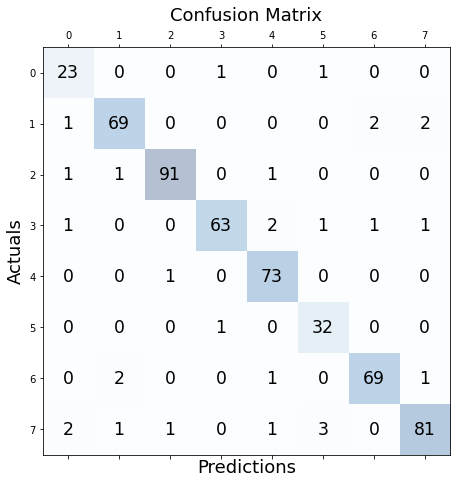

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

This validation accuracy is an overly optimistic estimate of the performance of the model post deployment since our validation set is very small (15% of the original training set).   